In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import pandas as pd
import sunpy
import sunpy.map
from sunpy.coordinates import (get_earth, get_horizons_coord,
                                Helioprojective, propagate_with_solar_surface)
from sunpy.physics.differential_rotation import solar_rotate_coordinate
import sunkit_image
import sunkit_image.coalignment as coalignment
import sunkit_image.enhance as enhance
import astropy
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import astropy.units as u
import astropy.constants as const
from astropy.io import fits
import h5py
from watroo import wow, Triangle, denoise

import cmcrameri.cm as cmcm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import (AutoLocator, AutoMinorLocator, 
    FixedLocator, FixedFormatter, LogLocator, StrMethodFormatter)
from ipywidgets import interactive, widgets
from IPython.display import display, clear_output
from astropy.visualization import (AsinhStretch, LinearStretch,
        LogStretch, ImageNormalize)
import os
from sun_blinker import SunBlinker
from copy import deepcopy   
from glob import glob
import cv2



In [2]:
eui_files = sorted(glob("../../src/EUI/HRI/euv174/20221024/solo_L2_eui-hri*.fits"))

In [3]:
len(eui_files)

360

In [4]:
eui_map_all = sunpy.map.Map(eui_files[21::40], sequence=True, memmap=True)
eui_centers = [m.center for m in eui_map_all]

<sunpy.map.mapsequence.MapSequence object at 0x7f80886966f0>
MapSequence of 9 elements, with maps from EUIMap
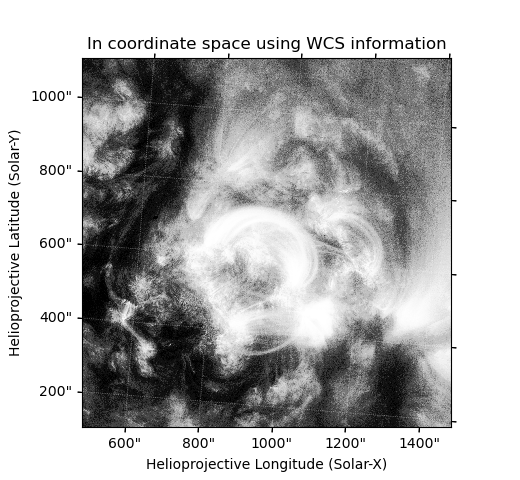
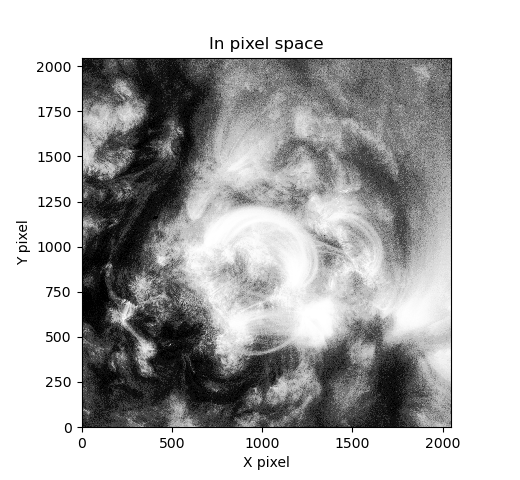
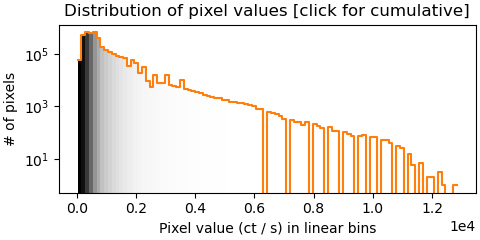
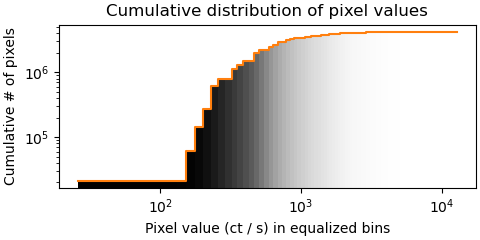
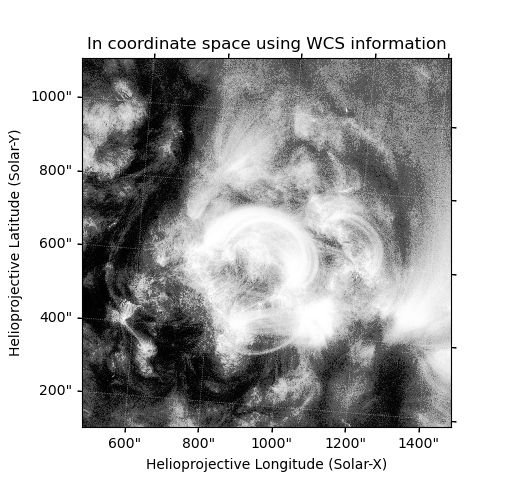
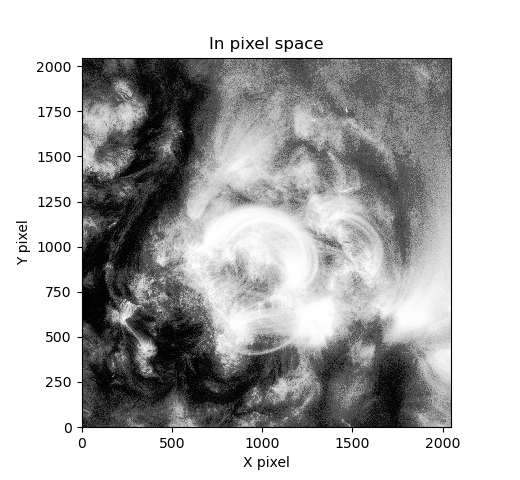
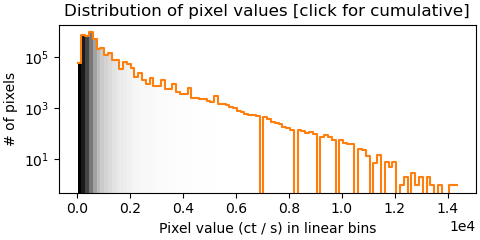
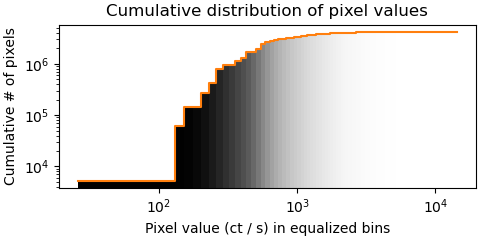
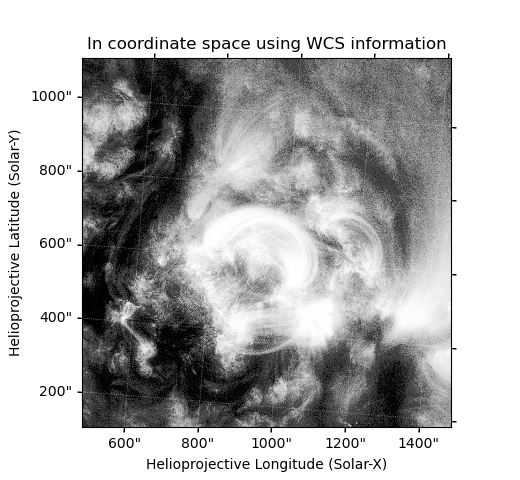
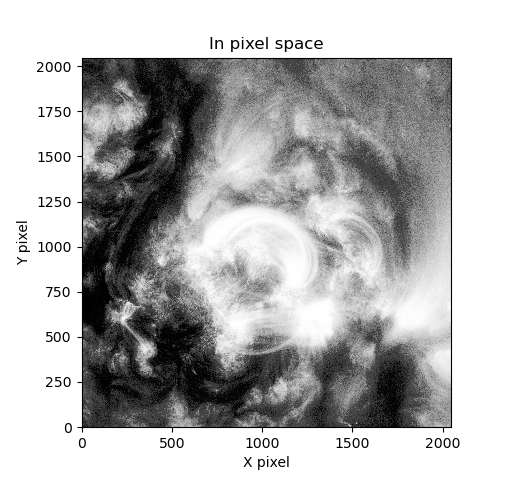
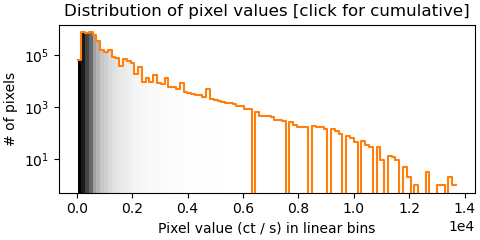
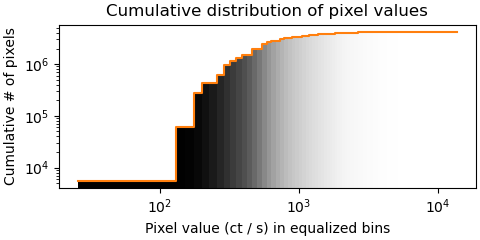
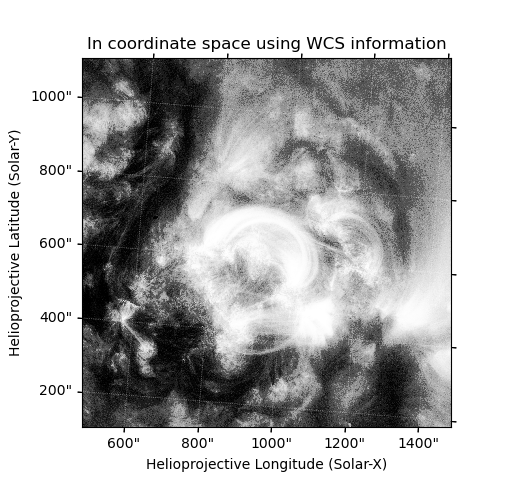
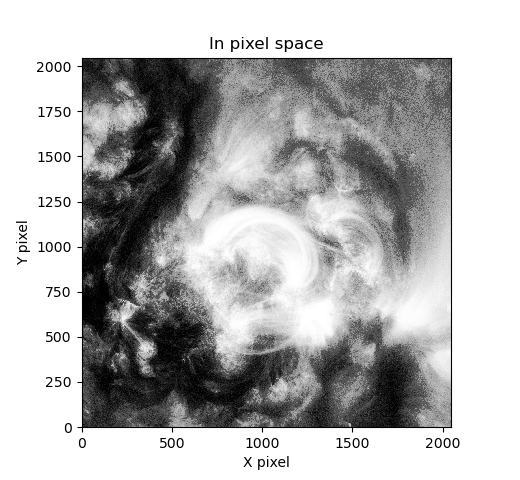
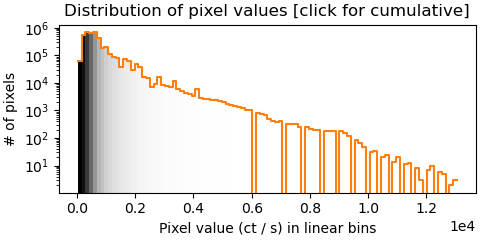
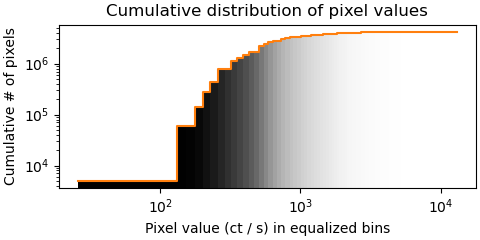
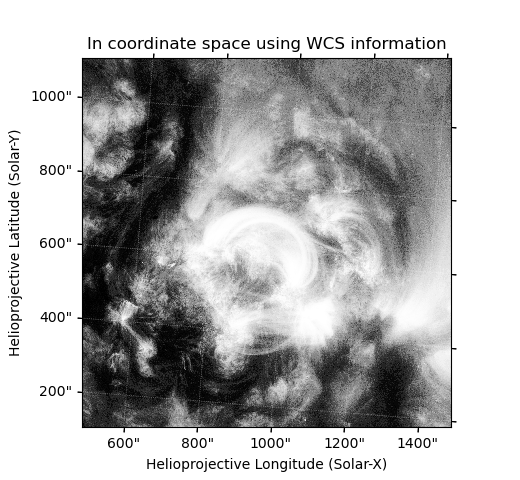
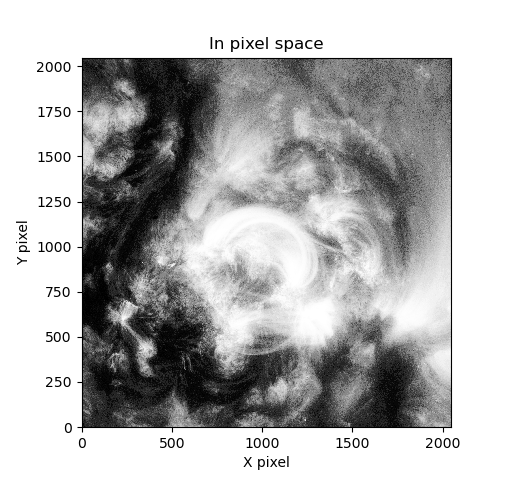
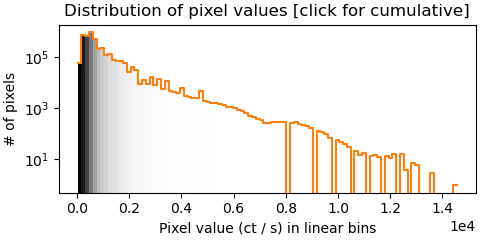
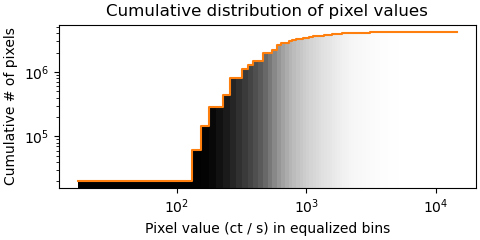
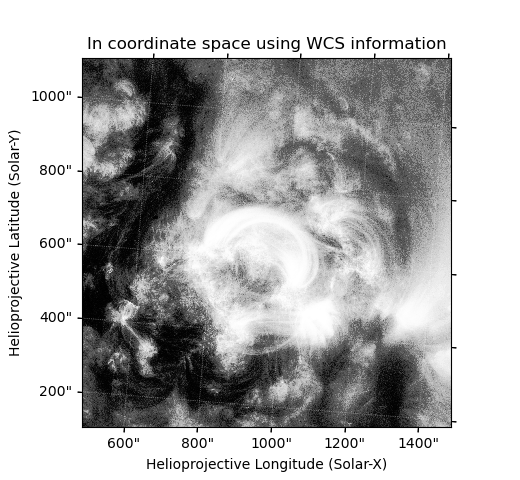
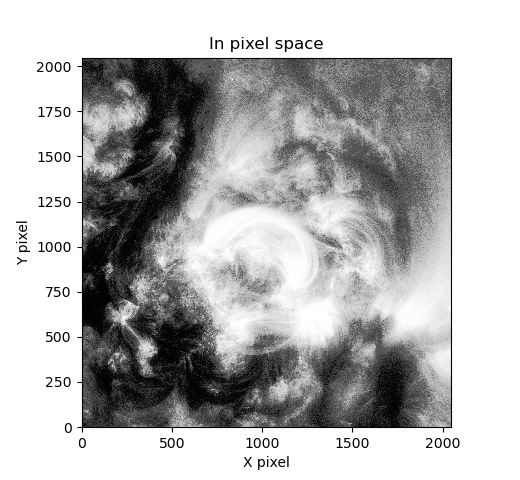
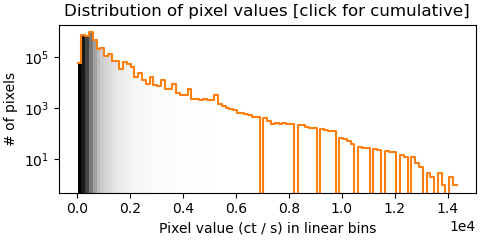
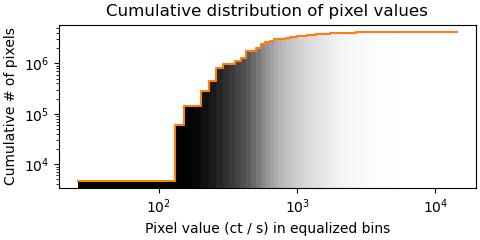
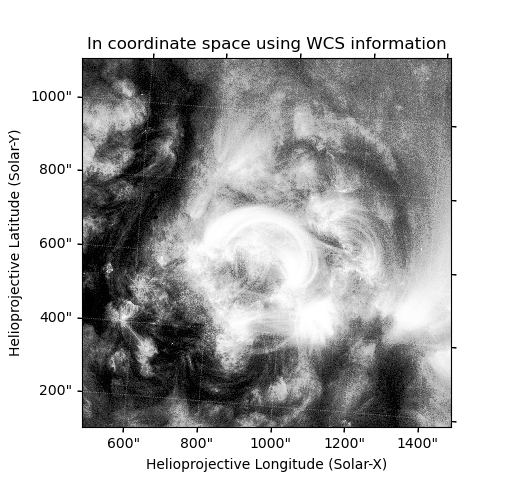
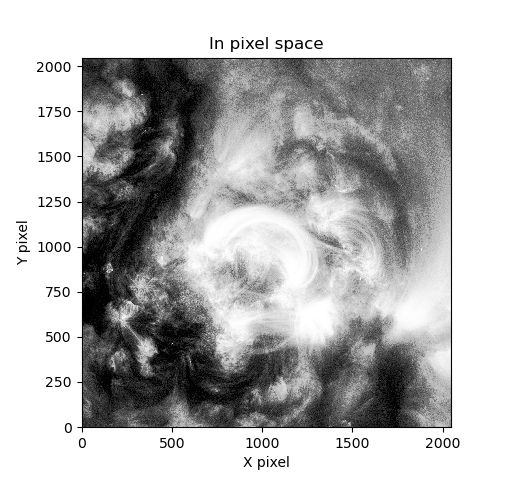
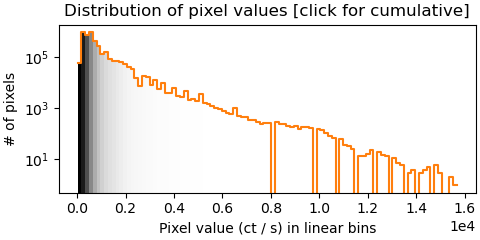
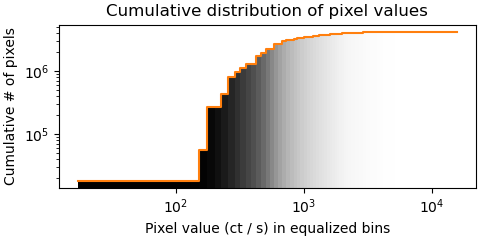
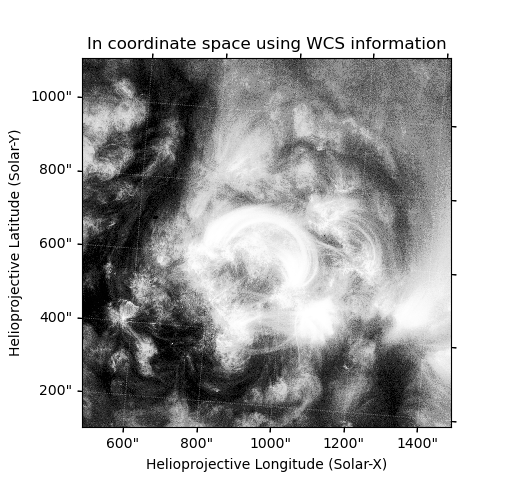
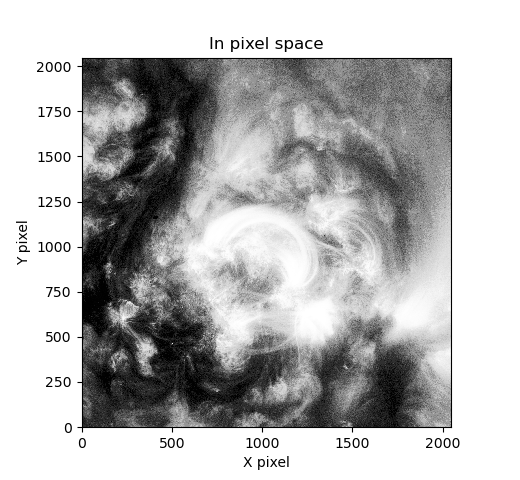
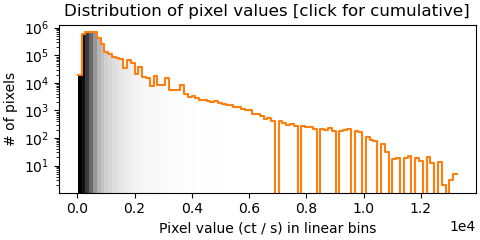
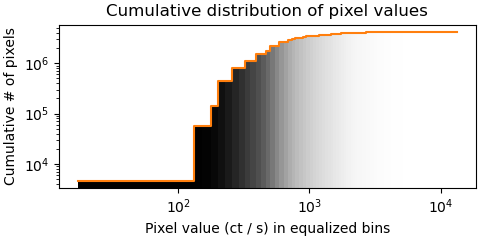
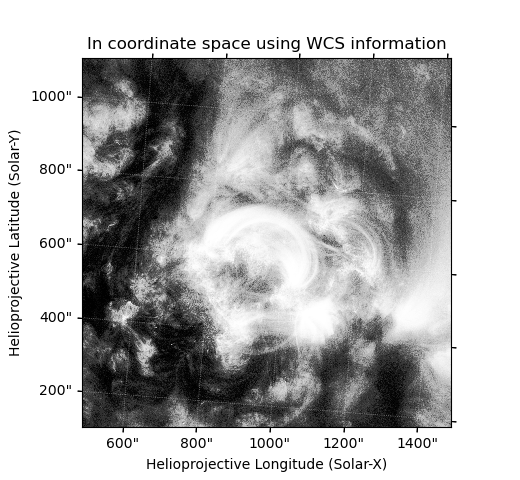
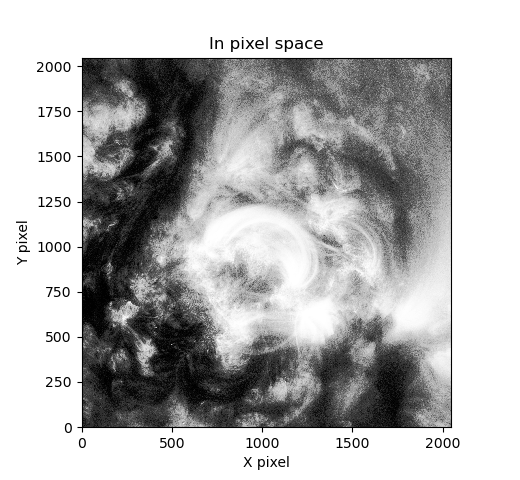
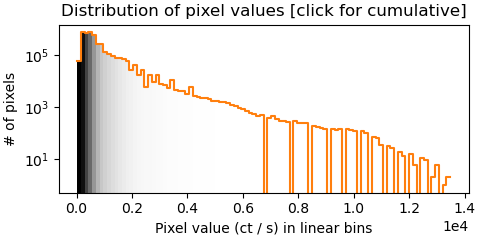
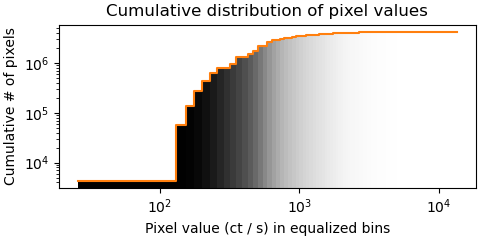

In [5]:
eui_map_all

In [6]:
test_image, _ = wow(eui_map_all[0].data,weights=[],denoise_coefficients=[])

In [7]:
[500,600]*u.pix,[670,760]

(<Quantity [500., 600.] pix>, [670, 760])

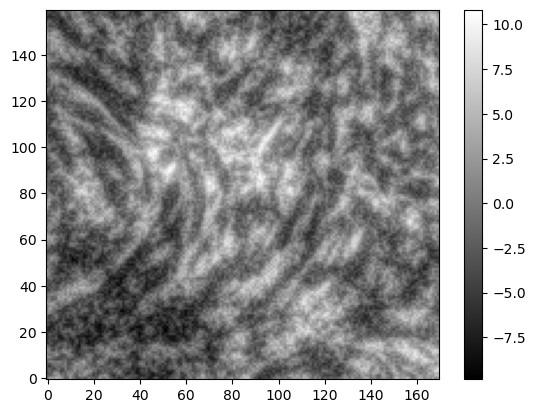

In [8]:
plt.imshow(test_image[600:760,500:670], cmap='gray',origin='lower')
plt.colorbar()

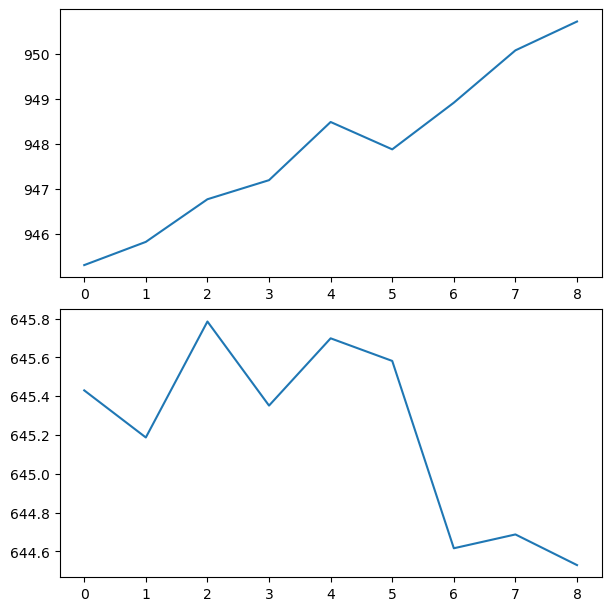

In [9]:
fig, ax = plt.subplots(2,1,figsize=(6,6),layout='constrained')
ax[0].plot([eui_center_.Tx.to_value(u.arcsec) for eui_center_ in eui_centers])
ax[1].plot([eui_center_.Ty.to_value(u.arcsec) for eui_center_ in eui_centers])

In [10]:
with h5py.File("../../src/EUI/HRI/euv174/20221024/coalign_shifts_step.h5","r") as f:
    eui_map_seq_coalign_shifts_x = f["x"][()]
    eui_map_seq_coalign_shifts_y = f["y"][()]
eui_map_seq_coalign_shifts = {"x":eui_map_seq_coalign_shifts_x[21::40]*u.arcsec,"y":eui_map_seq_coalign_shifts_y[21::40]*u.arcsec}

In [11]:
eui_map_seq_coalign = coalignment.mapsequence_coalign_by_match_template(eui_map_all,shift=eui_map_seq_coalign_shifts)

In [12]:
solar_rotate_coordinate(eui_map_all[0].center, observer=eui_map_all[-1].observer_coordinate).Tx, solar_rotate_coordinate(eui_map_all[0].center, observer=eui_map_all[-1].observer_coordinate).Ty

(<Longitude 951.30151718 arcsec>, <Latitude 645.09719245 arcsec>)

In [13]:
Txshift_hri, Tyshift_hri = (1.66986 + 2.49223)*u.arcsec,(7.60204 - 2.76366 )*u.arcsec
# eui_map_seq_coalign_shift = eui_map_seq_coalign.shift_reference_coord(Txshift_hri,Tyshift_hri)

In [14]:
eis_195_velmap_derot_repro_shifted_hrifov = sunpy.map.Map("../../src/EIS/DHB_007_v2/20221025T0023/sunpymaps/eis_195_velmap_derot_repro_hrifov.fits")
eis_hhflare_195_velmap_derot_repro_hrifov = sunpy.map.Map("../../src/coalign_map/20221024/eis_hhflare_195_velmap_derot_repro_hrifov.fits")

In [15]:
eui_map_181 = eui_map_seq_coalign[4].shift_reference_coord(Txshift_hri,Tyshift_hri)
eui_map_181.meta["rsun_ref"] = eis_195_velmap_derot_repro_shifted_hrifov.meta["rsun_ref"]
eui_wcs_all = eui_map_181.wcs

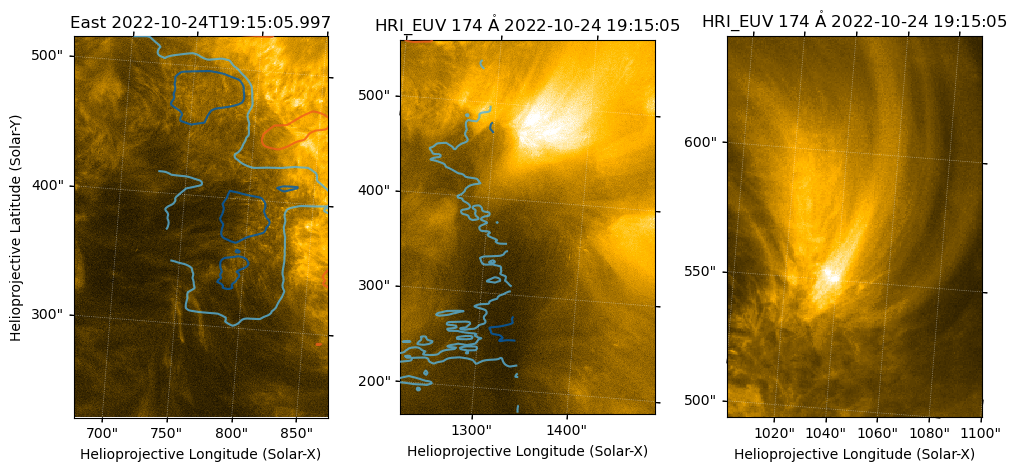

In [16]:

map = eui_map_181
eui_map_region_east = map.submap([400,200]*u.pix,top_right=[800,800]*u.pix)
eui_map_region_west = map.submap([1500,0]*u.pix,top_right=[2048,800]*u.pix)
eui_map_region_center = map.submap([1100,700]*u.pix,top_right=[1300,1000]*u.pix)

fig = plt.figure(figsize=(10,7),constrained_layout=True)
ax1 = fig.add_subplot(1,3,1,projection=eui_map_region_east)
ax2 = fig.add_subplot(1,3,2,projection=eui_map_region_west)
ax3 = fig.add_subplot(1,3,3,projection=eui_map_region_center)

eui_map_region_east.plot(axes=ax1,norm=ImageNormalize(vmin=10,vmax=4000,stretch=AsinhStretch(0.1)))
eui_map_region_west.plot(axes=ax2,norm=ImageNormalize(vmin=10,vmax=4000,stretch=AsinhStretch(0.1)))
eui_map_region_center.plot(axes=ax3,norm=ImageNormalize(vmin=10,vmax=1e4,stretch=AsinhStretch(0.3)))

ax1.set_title(f"East {map.date}")

ax2.set_ylabel(" ")
ax3.set_ylabel(" ")

for ax_ in (ax1,ax2):
    bounds = ax_.axis()
    eis_195_velmap_derot_repro_shifted_hrifov.draw_contours(levels=[-10,-5,5,10],colors=["#005CAF","#58B2DC","#F05E1C","#E83015"],alpha=0.8,
                                                        axes=ax_)
    ax_.axis(bounds)
# fig.clf()
# plt.colorbar(ax1.images[0],ax=ax1)

In [17]:
laplcian_kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
sharpen_weight = 0
eui_map_region_east_data_sharp = (1 + sharpen_weight)*eui_map_region_east.data - sharpen_weight*cv2.GaussianBlur(eui_map_region_east.data,(1,1),cv2.BORDER_DEFAULT)
eui_map_region_east_sharp = sunpy.map.Map(eui_map_region_east_data_sharp,eui_map_region_east.meta)

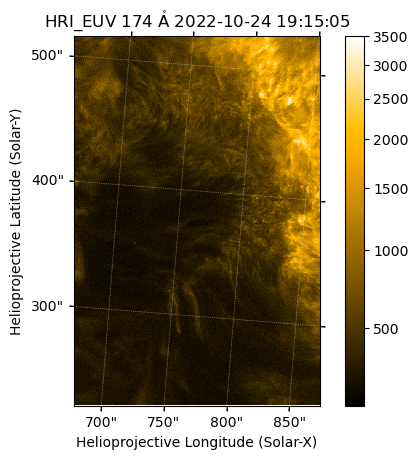

In [18]:
eui_map_region_east_sharp.plot_settings["norm"] = ImageNormalize(stretch=AsinhStretch(0.3))
eui_map_region_east_sharp.plot()
plt.colorbar()

In [19]:
eui_map_region_east_sharp.data.shape

(601, 401)

(-0.5, 170.5, -0.5, 160.5)

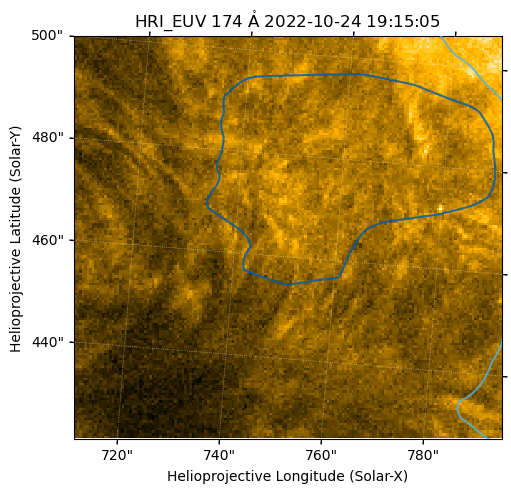

In [20]:
eui_map_region_east_zoomin_1 = eui_map_region_east_sharp.submap([100,400]*u.pix,
                                                        top_right=[270,560]*u.pix)
eui_map_region_east_zoomin_1.plot_settings["norm"] = ImageNormalize(vmin=150,vmax=1.5e3,stretch=AsinhStretch(0.4))
# eui_map_region_east_zoomin_1.plot_settings["cmap"] = plt.get_cmap("sdoaia171").reversed()
fig = plt.figure(figsize=(5,5),layout="constrained")
ax = fig.add_subplot(111,projection=eui_map_region_east_zoomin_1)

eui_map_region_east_zoomin_1.plot(axes=ax)

bounds = ax.axis()
eis_195_velmap_derot_repro_shifted_hrifov.draw_contours(levels=[-10,-5,5,10],colors=["#005CAF","#58B2DC","#F05E1C","#E83015"],alpha=0.8,
                                                        axes=ax)
ax.axis(bounds)

In [21]:
eui_map_region_east_zoomin_1_mgn = sunpy.map.Map(enhance.mgn(eui_map_region_east_zoomin_1.data),eui_map_region_east_zoomin_1.meta)

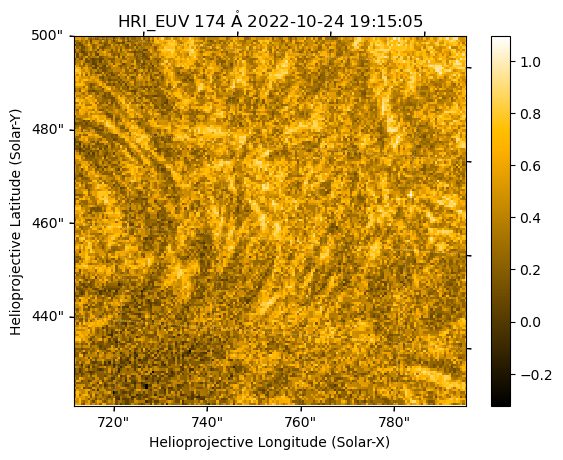

In [22]:
eui_map_region_east_zoomin_1_mgn.plot(norm=ImageNormalize())
plt.colorbar()

In [23]:
eui_map_region_east_zoomin_1_wow_std = sunpy.map.Map(wow(eui_map_region_east_zoomin_1.data.astype(np.float64),weights=[],denoise_coefficients=[])[0],
                                                     eui_map_region_east_zoomin_1.meta)

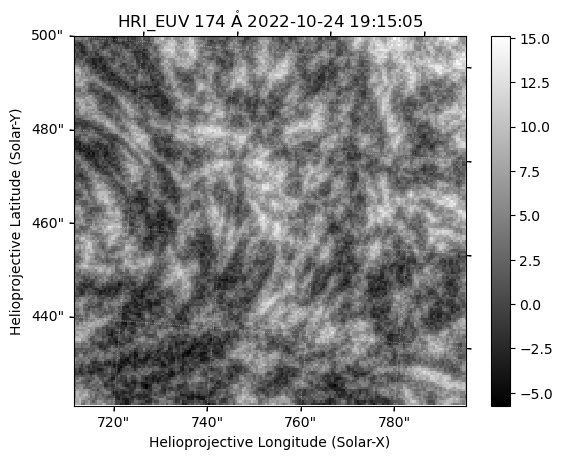

In [24]:
eui_map_region_east_zoomin_1_wow_std.plot(cmap='gray',norm=ImageNormalize())
plt.colorbar()

In [25]:
eui_map_region_east_zoomin_1_denoise = sunpy.map.Map(denoise(eui_map_region_east_zoomin_1.data.astype(np.float64), [3, 3], Triangle),
                                                     eui_map_region_east_zoomin_1.meta)

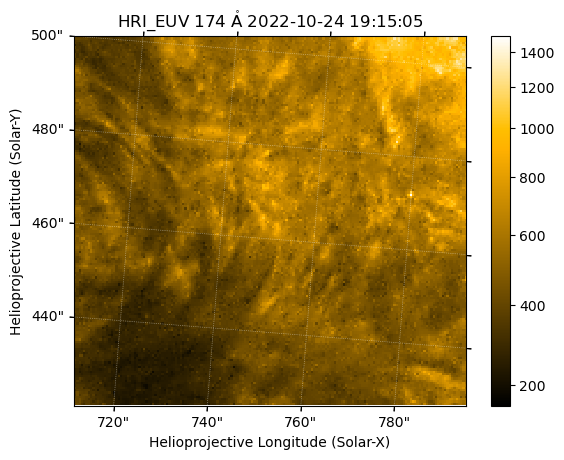

In [26]:
eui_map_region_east_zoomin_1_denoise.plot(norm=ImageNormalize(vmin=150,vmax=1.5e3,stretch=AsinhStretch(0.4)))
plt.colorbar()

(-0.5, 210.5, -0.5, 200.5)

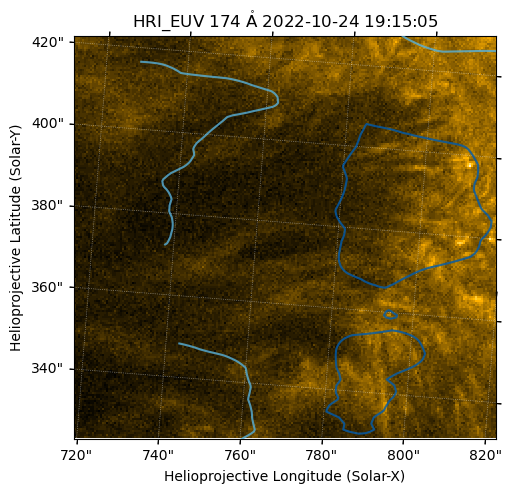

In [27]:
eui_map_region_east_zoomin_2 = eui_map_region_east_sharp.submap([100,200]*u.pix,
                                                        top_right=[310,400]*u.pix)
eui_map_region_east_zoomin_2.plot_settings["norm"] = ImageNormalize(vmin=100,vmax=1.5e3,stretch=AsinhStretch(0.4))
# eui_map_region_east_zoomin_1.plot_settings["cmap"] = plt.get_cmap("sdoaia171").reversed()
fig = plt.figure(figsize=(5,5),layout="constrained")

ax = fig.add_subplot(111,projection=eui_map_region_east_zoomin_2)
eui_map_region_east_zoomin_2.plot(axes=ax)

bounds = ax.axis()
eis_195_velmap_derot_repro_shifted_hrifov.draw_contours(levels=[-10,-5,5,10],colors=["#005CAF","#58B2DC","#F05E1C","#E83015"],alpha=0.8,
                                                        axes=ax)
ax.axis(bounds)

(-0.5, 140.5, -0.5, 160.5)

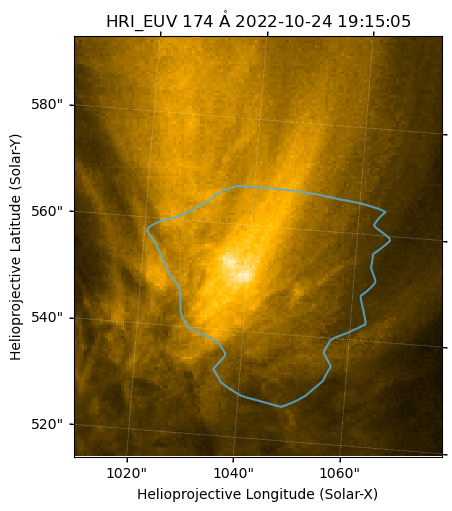

In [28]:
eui_map_region_center_zoomin_1 = eui_map_region_center.submap([20,40]*u.pix,
                                                        top_right=[160,200]*u.pix)
eui_map_region_center_zoomin_1.plot_settings["norm"] = ImageNormalize(vmin=5e2,vmax=1.2e4,stretch=AsinhStretch(0.4))

fig = plt.figure(figsize=(5,5),layout="constrained")
ax = fig.add_subplot(111,projection=eui_map_region_center_zoomin_1)
eui_map_region_center_zoomin_1.plot(axes=ax)

bounds = ax.axis()
eis_hhflare_195_velmap_derot_repro_hrifov.draw_contours(levels=[-10,-5,5,10]
            ,colors=["#005CAF","#58B2DC","#F05E1C","#E83015"],alpha=0.8,axes=ax)
ax.axis(bounds)

(-0.5, 270.5, -0.5, 300.5)

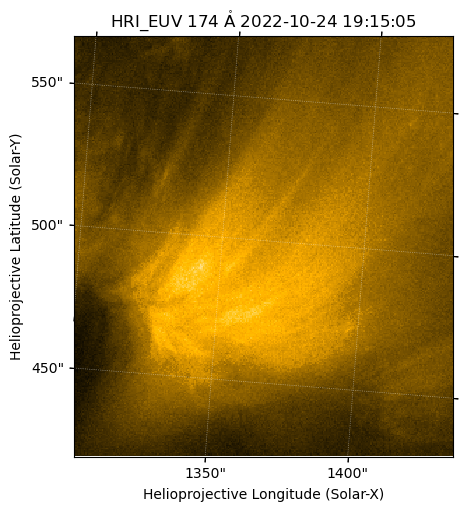

In [29]:
eui_map_region_west_zoomin_1 = eui_map_region_west.submap([200,500]*u.pix,
                                                        top_right=[470,800]*u.pix)
eui_map_region_west_zoomin_1.plot_settings["norm"] = ImageNormalize(vmin=500,vmax=6e3,stretch=AsinhStretch(0.4))
fig = plt.figure(figsize=(5,5),layout="constrained")
ax = fig.add_subplot(111,projection=eui_map_region_west_zoomin_1)
eui_map_region_west_zoomin_1.plot(axes=ax)

bounds = ax.axis()
eis_195_velmap_derot_repro_shifted_hrifov.draw_contours(levels=[-10,-5,5,10],colors=["#005CAF","#58B2DC","#F05E1C","#E83015"],alpha=0.8,
                                                        axes=ax)
ax.axis(bounds)

(-0.5, 200.5, -0.5, 300.5)

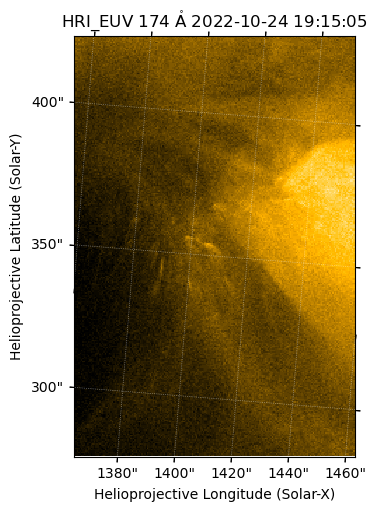

In [30]:
eui_map_region_west_zoomin_2 = eui_map_region_west.submap([300,200]*u.pix,
                                                        top_right=[500,500]*u.pix)
eui_map_region_west_zoomin_2.plot_settings["norm"] = ImageNormalize(vmin=300,vmax=2.7e3,stretch=AsinhStretch(0.4))
fig = plt.figure(figsize=(5,5),layout="constrained")
ax = fig.add_subplot(111,projection=eui_map_region_west_zoomin_2)
eui_map_region_west_zoomin_2.plot(axes=ax)

bounds = ax.axis()
eis_195_velmap_derot_repro_shifted_hrifov.draw_contours(levels=[-10,-5,5,10],colors=["#005CAF","#58B2DC","#F05E1C","#E83015"],alpha=0.8,
                                                        axes=ax)
ax.axis(bounds)

(-0.5, 160.5, -0.5, 180.5)

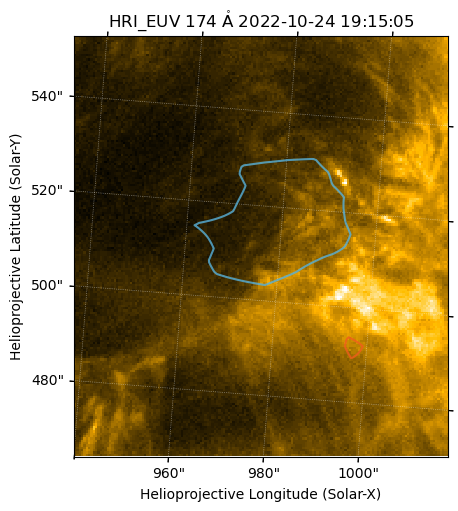

In [65]:
eui_map_region_center_zoomin_2 = eui_map_181.submap([970,650]*u.pix,
                                                        top_right=[1130,830]*u.pix)
eui_map_region_center_zoomin_2.plot_settings["norm"] = ImageNormalize(vmin=4e2,vmax=5.e3,stretch=AsinhStretch(0.3))

fig = plt.figure(figsize=(5,5),layout="constrained")
ax = fig.add_subplot(111,projection=eui_map_region_center_zoomin_2)
eui_map_region_center_zoomin_2.plot(axes=ax)

bounds = ax.axis()
eis_hhflare_195_velmap_derot_repro_hrifov.draw_contours(levels=[-10,-5,5,10]
            ,colors=["#005CAF","#58B2DC","#F05E1C","#E83015"],alpha=0.8,axes=ax)
ax.axis(bounds)

(array([1.3825e+04, 7.5800e+03, 4.0160e+03, 1.9540e+03, 1.0210e+03,
        5.6600e+02, 1.4600e+02, 2.6000e+01, 5.0000e+00, 2.0000e+00]),
 array([ 426.56054688,  984.90087891, 1543.24121094, 2101.58154297,
        2659.921875  , 3218.26220703, 3776.60253906, 4334.94287109,
        4893.28320312, 5451.62353516, 6009.96386719]),
 <BarContainer object of 10 artists>)

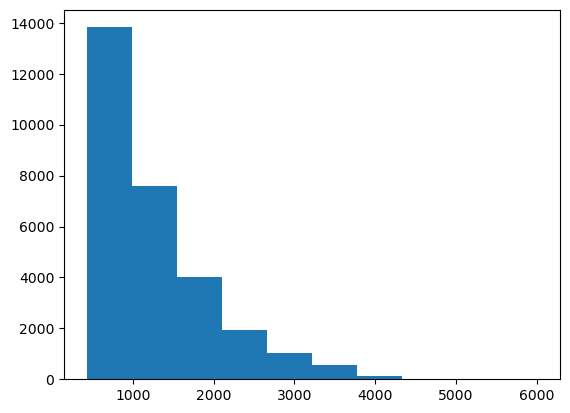

In [60]:
plt.hist(eui_map_region_center_zoomin_2.data.flatten())

In [31]:
def get_map_edge_coords(map):
    map_edges = sunpy.map.map_edges(map)

    x_pix = []
    y_pix = []

    for ii in range(map_edges[1].shape[0]):
        x_pix.append(map_edges[1][ii,0].value)
        y_pix.append(map_edges[1][ii,1].value)

    for ii in range(map_edges[3].shape[0]):
        x_pix.append(map_edges[3][ii,0].value)
        y_pix.append(map_edges[3][ii,1].value)

    for ii in range(map_edges[0].shape[0]-1,-1,-1):
        x_pix.append(map_edges[0][ii,0].value)
        y_pix.append(map_edges[0][ii,1].value)

    for ii in range(map_edges[2].shape[0]-1,-1,-1):
        x_pix.append(map_edges[2][ii,0].value)
        y_pix.append(map_edges[2][ii,1].value)
    
    return map.pixel_to_world(x_pix*u.pix,y_pix*u.pix)

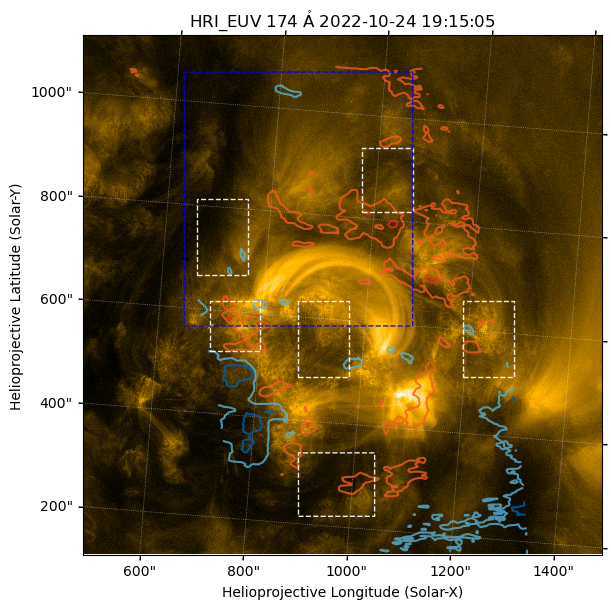

In [32]:
eui_map_region_noupflow_1 = map.submap([450,1100]*u.pix,
                                       top_right=[650,1400]*u.pix)

eui_map_region_noupflow_2 = map.submap([500,800]*u.pix,
                                        top_right=[700,1000]*u.pix)

eui_map_region_noupflow_3 = map.submap([850,700]*u.pix,
                                        top_right=[1050,1000]*u.pix)

eui_map_region_noupflow_4 = map.submap([1100,1350]*u.pix,
                                        top_right=[1300,1600]*u.pix)

eui_map_region_noupflow_5 = map.submap([1500,700]*u.pix,
                                        top_right=[1700,1000]*u.pix)

eui_map_region_noupflow_6 = map.submap([850,150]*u.pix,
                                        top_right=[1150,400]*u.pix)

# eui_map_region_coalign = map.submap([650,100]*u.pix,
#                                         top_right=[1300,750]*u.pix)

eui_map_region_coalign = map.submap([400,900]*u.pix,
                                        top_right=[1300,1900]*u.pix)

fig = plt.figure(figsize=(6,6),constrained_layout=True)

ax = fig.add_subplot(111,projection=map)
map.plot(axes=ax,norm=ImageNormalize(vmin=100,vmax=1.2e4,stretch=AsinhStretch(0.05))
        )

bounds = ax.axis()
eis_195_velmap_derot_repro_shifted_hrifov.draw_contours(levels=[-10,-5,5,10],colors=["#005CAF","#58B2DC","#F05E1C","#E83015"],alpha=0.8,
                                                        axes=ax)
ax.axis(bounds)
ax.plot_coord(get_map_edge_coords(eui_map_region_noupflow_1),color="w",lw=1,ls="--",alpha=0.9,)
ax.plot_coord(get_map_edge_coords(eui_map_region_noupflow_2),color="w",lw=1,ls="--",alpha=0.9,)
ax.plot_coord(get_map_edge_coords(eui_map_region_noupflow_3),color="w",lw=1,ls="--",alpha=0.9,)
ax.plot_coord(get_map_edge_coords(eui_map_region_noupflow_4),color="w",lw=1,ls="--",alpha=0.9,)
ax.plot_coord(get_map_edge_coords(eui_map_region_noupflow_5),color="w",lw=1,ls="--",alpha=0.9,)
ax.plot_coord(get_map_edge_coords(eui_map_region_noupflow_6),color="w",lw=1,ls="--",alpha=0.9,)
ax.plot_coord(get_map_edge_coords(eui_map_region_coalign),color="b",lw=1,ls="--",alpha=0.9,)

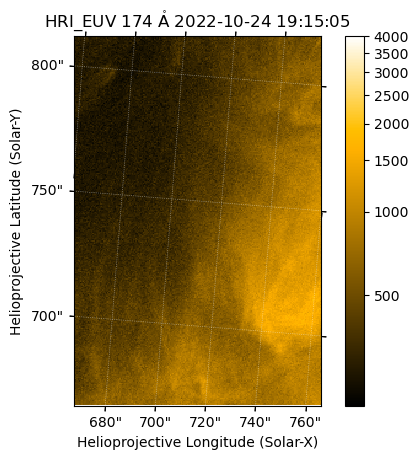

In [33]:
eui_map_region_noupflow_1.plot(norm=ImageNormalize(vmin=100,vmax=4e3,stretch=AsinhStretch(0.1)))
plt.colorbar()

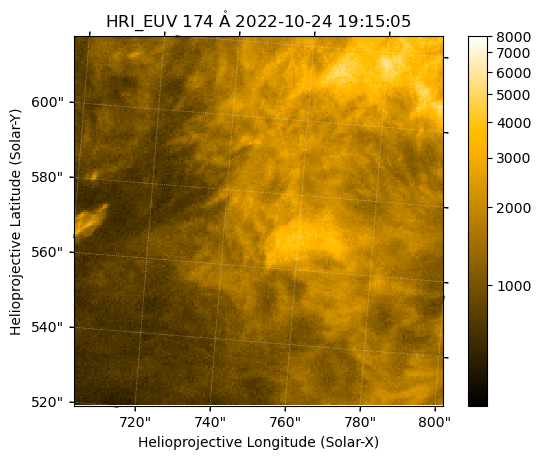

In [34]:
eui_map_region_noupflow_2.plot(norm=ImageNormalize(vmin=100,vmax=8e3,stretch=AsinhStretch(0.1)))
plt.colorbar()

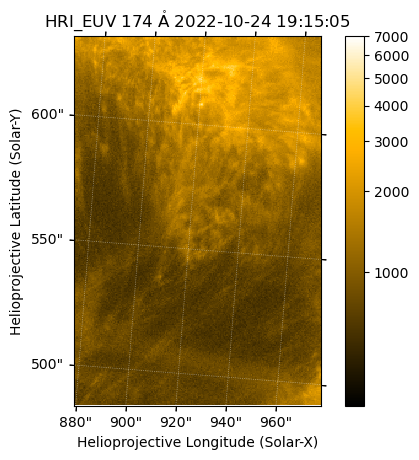

In [35]:
eui_map_region_noupflow_3.plot(norm=ImageNormalize(vmin=100,vmax=7e3,stretch=AsinhStretch(0.1)))
plt.colorbar()

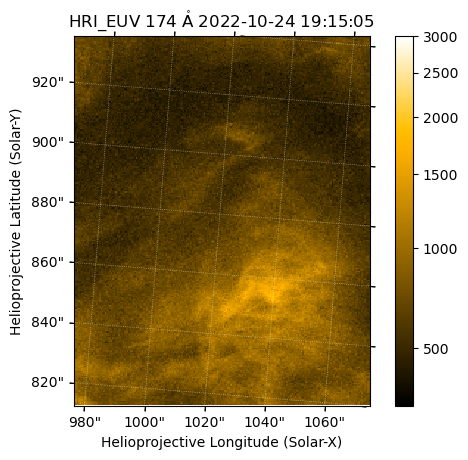

In [36]:
eui_map_region_noupflow_4.plot(norm=ImageNormalize(vmin=250,vmax=3e3,stretch=AsinhStretch(0.3)))
plt.colorbar()

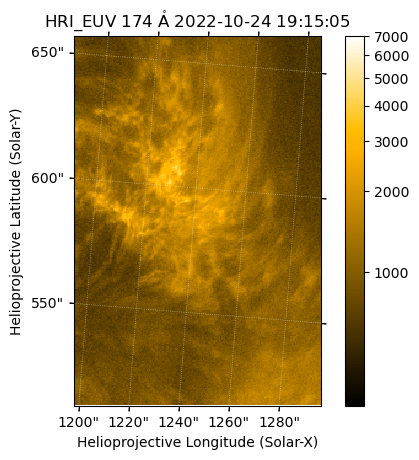

In [37]:
eui_map_region_noupflow_5.plot(norm=ImageNormalize(vmin=100,vmax=7e3,stretch=AsinhStretch(0.1)))
plt.colorbar()

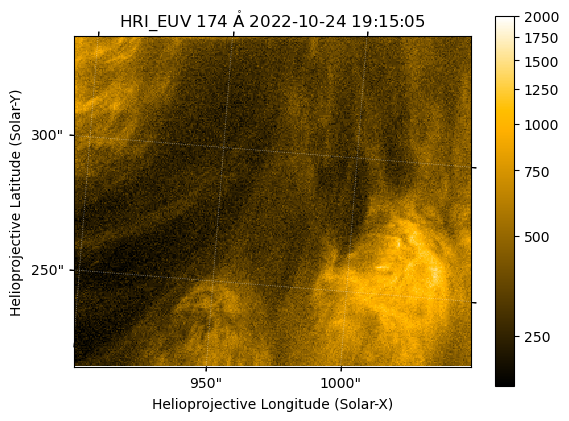

In [38]:
eui_map_region_noupflow_6.plot(norm=ImageNormalize(vmin=150,vmax=2e3,stretch=AsinhStretch(0.15)))
plt.colorbar()

In [39]:
def get_map_edge_coords(map):
    map_edges = sunpy.map.map_edges(map)

    x_pix = []
    y_pix = []

    for ii in range(map_edges[1].shape[0]):
        x_pix.append(map_edges[1][ii,0].value)
        y_pix.append(map_edges[1][ii,1].value)

    for ii in range(map_edges[3].shape[0]):
        x_pix.append(map_edges[3][ii,0].value)
        y_pix.append(map_edges[3][ii,1].value)

    for ii in range(map_edges[0].shape[0]-1,-1,-1):
        x_pix.append(map_edges[0][ii,0].value)
        y_pix.append(map_edges[0][ii,1].value)

    for ii in range(map_edges[2].shape[0]-1,-1,-1):
        x_pix.append(map_edges[2][ii,0].value)
        y_pix.append(map_edges[2][ii,1].value)
    
    return map.pixel_to_world(x_pix*u.pix,y_pix*u.pix)

In [40]:
aia_171_map = sunpy.map.Map("../../src/AIA/20221024/171/ARcutout_lvl15/aia.lev1_euv_12s.2022-10-24T192003Z.171.image.fits")

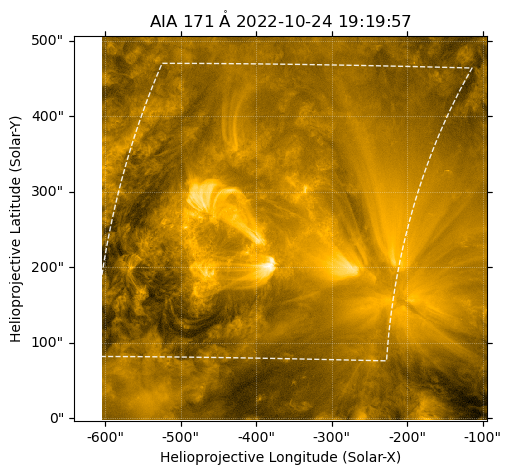

In [41]:
fig = plt.figure(figsize=(5,5),constrained_layout=True)
ax = fig.add_subplot(111,projection=aia_171_map)
aia_171_map.plot(axes=ax,)
ax.plot_coord(get_map_edge_coords(eui_map_181),color="w",lw=1,ls="--",alpha=0.9,)


In [42]:
aia_171_east_zoomin_1_hri_fov = aia_171_map.reproject_to(eui_map_region_east_zoomin_1.wcs) 

/home/yjzhu/anaconda3/envs/sunpy/lib/python3.12/site-packages/astropy/visualization/mpl_normalize.py:179: RuntimeWarning: invalid value encountered in divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/home/yjzhu/anaconda3/envs/sunpy/lib/python3.12/site-packages/astropy/visualization/mpl_normalize.py:179: RuntimeWarning: invalid value encountered in divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/home/yjzhu/anaconda3/envs/sunpy/lib/python3.12/site-packages/astropy/visualization/mpl_normalize.py:179: RuntimeWarning: invalid value encountered in divide
  np.true_divide(values, self.vmax - self.vmin, out=values)


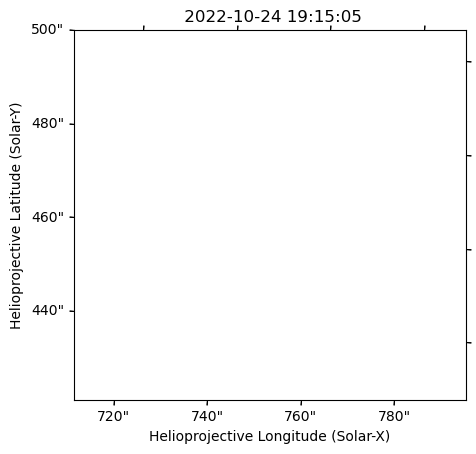

In [43]:
aia_171_east_zoomin_1_hri_fov.plot(norm=ImageNormalize())

/home/yjzhu/anaconda3/envs/sunpy/lib/python3.12/site-packages/astropy/visualization/mpl_normalize.py:179: RuntimeWarning: invalid value encountered in divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/home/yjzhu/anaconda3/envs/sunpy/lib/python3.12/site-packages/astropy/visualization/mpl_normalize.py:179: RuntimeWarning: invalid value encountered in divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/home/yjzhu/anaconda3/envs/sunpy/lib/python3.12/site-packages/astropy/visualization/mpl_normalize.py:179: RuntimeWarning: invalid value encountered in divide
  np.true_divide(values, self.vmax - self.vmin, out=values)


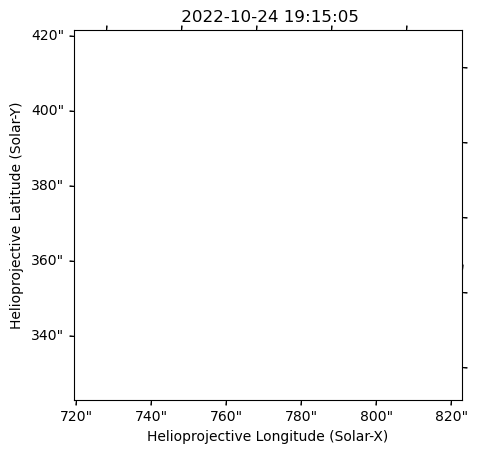

In [44]:
aia_171_east_zoomin_2_hri_fov = aia_171_map.reproject_to(eui_map_region_east_zoomin_2.wcs)
aia_171_east_zoomin_2_hri_fov.plot(norm=ImageNormalize())

In [45]:
aia_171_east = aia_171_map.submap(eui_map_region_east.bottom_left_coord,top_right=eui_map_region_east.top_right_coord)

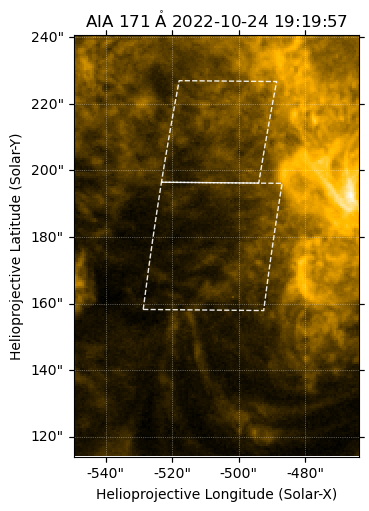

In [46]:
fig = plt.figure(figsize=(4,5),layout="constrained")
ax = fig.add_subplot(111,projection=aia_171_east)
aia_171_east.plot(norm=ImageNormalize(stretch=AsinhStretch(0.1)),axes=ax)
ax.plot_coord(get_map_edge_coords(eui_map_region_east_zoomin_1),color="w",lw=1,ls="--",alpha=0.9)
ax.plot_coord(get_map_edge_coords(eui_map_region_east_zoomin_2),color="w",lw=1,ls="--",alpha=0.9)

In [47]:
aia_193_map = sunpy.map.Map("../../src/AIA/20221024/193/ARcutout_lvl15/aia.lev1_euv_12s.2022-10-24T192003Z.193.image.fits")

In [48]:
aia_193_east = aia_193_map.submap(eui_map_region_east.bottom_left_coord,top_right=eui_map_region_east.top_right_coord)

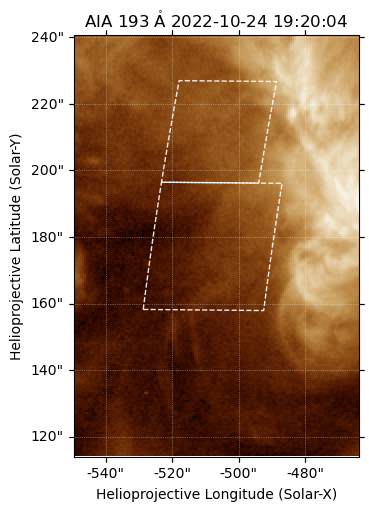

In [49]:
fig = plt.figure(figsize=(4,5),layout="constrained")
ax = fig.add_subplot(111,projection=aia_193_east)
aia_193_east.plot(norm=ImageNormalize(stretch=AsinhStretch(0.1)),axes=ax)
ax.plot_coord(get_map_edge_coords(eui_map_region_east_zoomin_1),color="w",lw=1,ls="--",alpha=0.9)
ax.plot_coord(get_map_edge_coords(eui_map_region_east_zoomin_2),color="w",lw=1,ls="--",alpha=0.9)